In [32]:
from pyspark.sql import SparkSession
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


spark = SparkSession.builder.getOrCreate()
sc = sc = spark.sparkContext

apache_logs = sc.textFile("apache_logs")


In [29]:


q ='207.241.237.101 - - [17/May/2015:10:05:51 +0000] "GET /blog/tags/regex HTTP/1.0" 200 14888 "http://www.semicomplete.com/blog/tags/C" "Mozilla/5.0 (compatible; archive.org_bot +http://www.archive.org/details/archive.org_bot)"'
q1 = 'fnianf'


def search_result(line):
    regular_expression = r"(?i)\b((?:https?:\/\/|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}\/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url =re.search(regular_expression, line)
    if url:
        url = url.group(0)
        url = url.replace('//www.','//')
        regular_expression1 = '(?<=\/\/)[^\.]+\.\w+'
        result = re.search(regular_expression1, url)
        if result:
            result = result.group(0)
            return result




lines =apache_logs.map(search_result) 
lines = lines.filter(lambda x: x is not None)
lines = lines.filter(lambda x: x !='semicomplete.com')
lines = lines.map(lambda x: (x,1))
lines = lines.reduceByKey(lambda a, b: a + b)
lines = lines.takeOrdered(10, lambda pair: -pair[1])
lines = pd.DataFrame(lines)
lines


,0,1
0,google.com,909
1,feedparser.org,364
2,search.msn,118
3,FeedBurner.com,108
4,help.yahoo,106
5,yandex.com,86
6,baidu.com,85
7,tt-rss.org,83
8,google.co,77
9,bing.com,63


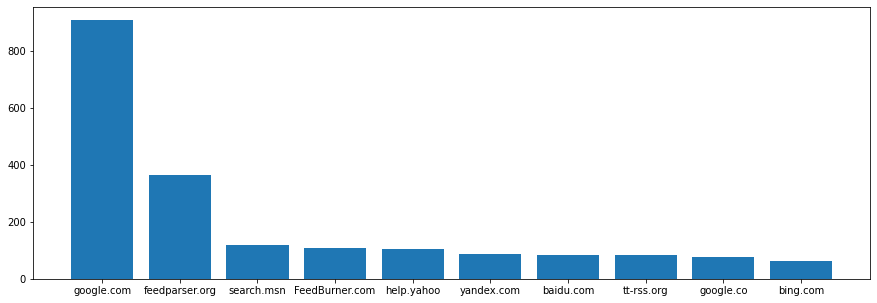

In [33]:
fig = plt.figure(figsize=(15,5))
plt.bar(lines[0],lines[1])

plt.show()

In [10]:

def search_result(line):
    regular_expression = r"(?i)\b((?:https?:\/\/|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}\/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url =re.search(regular_expression, line)
    if url:
        url = url.group(0)
        url = url.replace('//www.','//')
        regular_expression1 = '(?<=\/\/)[^\.]+\.\w+'
        result = re.search(regular_expression1, url)
        if result:
            result = result.group(0)
            return result


line = '192.30.34.115 - - [17/May/2015:18:05:21 +0000] "HEAD /blog/geekery/jquery-interface-puffer.html HTTP/1.1" 200 - "http://www.adictosalared.com" "Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)"'
print(search_result(line))


adictosalared.com


In [30]:

'www.'

pyspark.rdd.PipelinedRDD